In [1]:
# !pip install pytorch_msssim
# !pip install wandb

In [2]:
import torch, random, numpy as np
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
print(f"Global seed set to {seed}")

Global seed set to 42


In [3]:
!wandb login 8285c1e86ba66976957cd9bdbae9e646b37bba8f

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [4]:
# !git clone https://github.com/ayannareda/Weather-Detection-Using-Images.git
# url - /kaggle/working/Weather-Detection-Using-Images/Data

### Dataset Loader

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import torchvision.transforms as transforms

class ImageFilenameDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.files = []
        for label_name in os.listdir(root):
            label_dir = os.path.join(root, label_name)
            if os.path.isdir(label_dir) and label_name.isdigit():
                for fname in sorted(os.listdir(label_dir)):
                    if fname.lower().endswith(('.jpg', '.png')):
                        path = os.path.join(label_dir, fname)
                        self.files.append((path, int(label_name)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

### Model Architecture


In [1]:
# StarGAN Generator with ResNet blocks and Self-Attention
import torch.nn as nn
import torch

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1), nn.InstanceNorm2d(dim), nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1), nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim//8, 1)
        self.key   = nn.Conv2d(in_dim, in_dim//8, 1)
        self.value = nn.Conv2d(in_dim, in_dim,    1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        b, c, h, w = x.size()
        proj_q = self.query(x).view(b, -1, h*w).permute(0,2,1)
        proj_k = self.key(x).view(b, -1, h*w)
        attn   = torch.softmax(torch.bmm(proj_q, proj_k), dim=-1)
        proj_v = self.value(x).view(b, -1, h*w)
        out = torch.bmm(proj_v, attn.permute(0,2,1)).view(b, c, h, w)
        out = self.gamma * out + x

        # Stable spatial attention map: softmax over spatial dims
        attn_map = attn.sum(dim=1).view(b, 1, h, w)
        attn_map = torch.softmax(attn_map.view(b, 1, -1), dim=-1).view(b, 1, h, w)
        out = out * (1 + attn_map)

        return out

class Generator(nn.Module):
    def __init__(self, in_ch=3, n_classes=5, n_blocks=6):
        super().__init__()
        self.n_classes = n_classes
        model = [nn.Conv2d(in_ch + n_classes, 64, 7, 1, 3), nn.InstanceNorm2d(64), nn.ReLU()]
        dim = 64
        for _ in range(2):
            model += [nn.Conv2d(dim, dim*2, 4, 2, 1), nn.InstanceNorm2d(dim*2), nn.ReLU()]
            dim *= 2
        for _ in range(n_blocks):
            model += [ResnetBlock(dim)]
        model += [SelfAttention(dim)]
        for _ in range(2):
            model += [nn.ConvTranspose2d(dim, dim//2, 4, 2, 1), nn.InstanceNorm2d(dim//2), nn.ReLU()]
            dim //= 2
        model += [nn.Conv2d(dim, in_ch, 7, 1, 3), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x, target_label):
        b, _, h, w = x.size()
        label_map = target_label.view(b, self.n_classes, 1, 1).expand(b, self.n_classes, h, w)
        inp = torch.cat([x, label_map], dim=1)
        return self.model(inp)

In [2]:
# StarGAN Discriminator with adversarial and classification heads
import torch.nn as nn
import torch.nn.utils as utils

class Discriminator(nn.Module):
    def __init__(self, in_ch=3, n_classes=5):
        super().__init__()
        layers = []
        dim = in_ch
        for out_dim in [64, 128, 256, 512]:
            layers += [utils.spectral_norm(nn.Conv2d(dim, out_dim, 4, 2, 1)), nn.LeakyReLU(0.01)]
            dim = out_dim
        self.main = nn.Sequential(*layers)
        self.adv_head = utils.spectral_norm(nn.Conv2d(512, 1, 3, 1, 1))
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc_cls = utils.spectral_norm(nn.Linear(512, n_classes))

    def forward(self, x):
        h = self.main(x)
        out_adv = self.adv_head(h)
        pooled = self.global_pool(h).view(h.size(0), -1)
        out_cls = self.fc_cls(pooled)
        return out_adv, out_cls

### Training Loop

In [8]:
from tqdm import tqdm
import os
import torch.nn.functional as F
import numpy as np
import torchvision.models as models
from pytorch_msssim import ssim
import wandb

# Perceptual model (VGG19 features)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = models.vgg19(pretrained=True).features[:16].to(device).eval()
for p in vgg.parameters(): p.requires_grad = False

if torch.cuda.device_count() > 1:
    vgg = nn.DataParallel(vgg)

# ImageNet normalization for VGG
imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
imagenet_std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)

def preprocess_vgg(x):
    # x: [B,3,H,W] in [-1,1] -> [0,1] -> normalize
    x = (x + 1) / 2
    return (x - imagenet_mean) / imagenet_std

# Helper: single VGG forward
def get_vgg_features(x):
    return vgg(preprocess_vgg(x))

# Now take features as inputs
def perceptual_loss_fn(fx, fy):
    return torch.nn.functional.l1_loss(fx, fy)

# Gram matrix and style loss (features only)
def gram_matrix(feat):
    b, c, h, w = feat.size()
    feat = feat.view(b, c, h*w)
    return torch.bmm(feat, feat.transpose(1, 2)) / (c * h * w)

def gram_loss_fn(fx, fy):
    gram_x = gram_matrix(fx)
    gram_y = gram_matrix(fy)
    return torch.nn.functional.mse_loss(gram_x, gram_y)

# Hinge loss for GANs
def d_hinge_loss(real_logits, fake_logits):
    loss_real = torch.mean(F.relu(1. - real_logits))
    loss_fake = torch.mean(F.relu(1. + fake_logits))
    return loss_real + loss_fake

def g_hinge_loss(fake_logits):
    return -torch.mean(fake_logits)

def train(G, D, train_loader, val_loader, optim_G, optim_D, device,
          epochs=50, lambda_cls=1.0, lambda_rec=6.0,
          lambda_perc=0.4, lambda_ssim=1.0, lambda_gram=0.2,
          checkpoint_dir='checkpoints', resume_path=None):
    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 1
    if resume_path and os.path.exists(resume_path):
        ckpt = torch.load(resume_path, map_location=device)
        G.load_state_dict(ckpt['G_state']); D.load_state_dict(ckpt['D_state'])
        optim_G.load_state_dict(ckpt['optim_G_state'])
        optim_D.load_state_dict(ckpt['optim_D_state'])
        start_epoch = ckpt.get('epoch', 1) + 1
        print(f"Resuming from epoch {start_epoch}")

    cls_criterion = torch.nn.CrossEntropyLoss()
    rec_criterion = torch.nn.L1Loss()
    G.to(device); D.to(device)

    for epoch in range(start_epoch, epochs+1):
        G.train(); D.train()
        train_stats = {'adv': [], 'cls': [], 'rec': [], 'perc': [], 'ssim': [], 'gram': []}
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]")
        for real_x, real_lbl in pbar:
            real_x, real_lbl = real_x.to(device), real_lbl.to(device)
            B = real_x.size(0)
            idx = torch.randperm(B); target_lbl = real_lbl[idx]
            target_oh = F.one_hot(target_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
            # Discriminator
            fake_x = G(real_x, target_oh).detach()
            optim_D.zero_grad()
            real_adv, real_cls = D(real_x)
            fake_adv, _ = D(fake_x)
            loss_D_adv = d_hinge_loss(real_adv, fake_adv)
            loss_D_cls = lambda_cls * cls_criterion(real_cls, real_lbl)
            loss_D = loss_D_adv + loss_D_cls
            loss_D.backward(); optim_D.step()

            # Generator
            optim_G.zero_grad()
            fake_x = G(real_x, target_oh)
            adv_out, cls_out = D(fake_x)
            rec_lbl_oh = F.one_hot(real_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
            rec_x = G(fake_x, rec_lbl_oh)

            # Compute VGG features once per tensor
            fx_feat = get_vgg_features(fake_x)
            real_feat = get_vgg_features(real_x)
            target_feat = real_feat[idx]
            # target_feat = get_vgg_features(real_x[idx])

            perc_loss = perceptual_loss_fn(fx_feat, real_feat)
            gram_loss = gram_loss_fn(fx_feat, target_feat)
            ssim_score = ssim(fake_x, real_x, data_range=2.0, size_average=True)
            loss_G_adv = g_hinge_loss(adv_out)
            loss_G_cls = lambda_cls * cls_criterion(cls_out, target_lbl)
            loss_G_rec = lambda_rec * rec_criterion(rec_x, real_x)
            loss_G_perc = lambda_perc * perc_loss
            loss_G_gram = lambda_gram * gram_loss
            loss_G_ssim = lambda_ssim * (1 - ssim_score)
            loss_G = loss_G_adv + loss_G_cls + loss_G_rec + loss_G_perc + loss_G_gram + loss_G_ssim
            loss_G.backward(); optim_G.step()

            # collect stats
            train_stats['adv'].append(loss_D_adv.item())
            train_stats['cls'].append(cls_criterion(cls_out, target_lbl).item())
            train_stats['rec'].append(rec_criterion(rec_x, real_x).item())
            train_stats['perc'].append(perc_loss.item())
            train_stats['ssim'].append(ssim_score.item())
            train_stats['gram'].append(gram_loss.item())
            pbar.set_postfix({k: np.mean(v) for k, v in train_stats.items()})

        # Validation
        G.eval(); D.eval()
        val_stats = {'adv': [], 'cls': [], 'rec': [], 'perc': [], 'ssim': [], 'gram': []}
        with torch.no_grad():
            vbar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]")
            for real_x, real_lbl in vbar:
                real_x, real_lbl = real_x.to(device), real_lbl.to(device)
                B = real_x.size(0)
                idx = torch.randperm(B); target_lbl = real_lbl[idx]
                target_oh = F.one_hot(target_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
                fake_x = G(real_x, target_oh)
                real_adv, _ = D(real_x)
                fake_adv, cls_out = D(fake_x)
                rec_lbl_oh = F.one_hot(real_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
                rec_x = G(fake_x, rec_lbl_oh)

                # Compute VGG features once per tensor
                fx_feat = get_vgg_features(fake_x)
                real_feat = get_vgg_features(real_x)
                target_feat = real_feat[idx]
                # target_feat = get_vgg_features(real_x[idx])

                val_perc = perceptual_loss_fn(fx_feat, real_feat)
                val_gram = gram_loss_fn(fx_feat, target_feat)
                val_ssim = ssim(fake_x, real_x, data_range=2.0, size_average=True)
                # Log Discriminator's hinge loss for val/adv
                val_stats['adv'].append(d_hinge_loss(real_adv, fake_adv).item())
                val_stats['cls'].append(cls_criterion(cls_out, target_lbl).item())
                val_stats['rec'].append(rec_criterion(rec_x, real_x).item())
                val_stats['perc'].append(val_perc.item())
                val_stats['ssim'].append(val_ssim.item())
                val_stats['gram'].append(val_gram.item())
                vbar.set_postfix({k: np.mean(v) for k, v in val_stats.items()})

        # Log metrics
        print(f"Epoch {epoch}: Train -> adv={np.mean(train_stats['adv']):.4f}, ",
              f"cls={np.mean(train_stats['cls']):.4f}, rec={np.mean(train_stats['rec']):.4f}, perc={np.mean(train_stats['perc']):.4f}, gram={np.mean(train_stats['gram']):.4f}, ssim={np.mean(train_stats['ssim']):.4f}")
        print(f"           Val   -> adv={np.mean(val_stats['adv']):.4f}, ",
              f"cls={np.mean(val_stats['cls']):.4f}, rec={np.mean(val_stats['rec']):.4f}, perc={np.mean(val_stats['perc']):.4f}, gram={np.mean(val_stats['gram']):.4f}, ssim={np.mean(val_stats['ssim']):.4f}")

        # wandb logging
        wandb.log({
            'epoch': epoch,
            'train/adv': np.mean(train_stats['adv']),
            'train/cls': np.mean(train_stats['cls']),
            'train/rec': np.mean(train_stats['rec']),
            'train/perc': np.mean(train_stats['perc']),
            'train/ssim': np.mean(train_stats['ssim']),
            'train/gram': np.mean(train_stats['gram']),
            'val/adv': np.mean(val_stats['adv']),
            'val/cls': np.mean(val_stats['cls']),
            'val/rec': np.mean(val_stats['rec']),
            'val/perc': np.mean(val_stats['perc']),
            'val/ssim': np.mean(val_stats['ssim']),
            'val/gram': np.mean(val_stats['gram'])
        })

        # Save checkpoint
        if epoch % 5 == 0 or epoch == epochs:
            ckpt_path = os.path.join(checkpoint_dir, f"ckpt_epoch_{epoch}.pt")
            torch.save({
                'epoch': epoch,
                'G_state': G.state_dict(),
                'D_state': D.state_dict(),
                'optim_G_state': optim_G.state_dict(),
                'optim_D_state': optim_D.state_dict()
            }, ckpt_path)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 203MB/s]  


In [9]:
# !pip install wandb pytorch-msssim

In [ ]:
import torch.nn as nn
# Example usage of train_starGAN function
import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate models
G = Generator().to(device)
D = Discriminator().to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    G = nn.DataParallel(G)
    D = nn.DataParallel(D)

# Optimizers
optim_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Transforms
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Create dataset and split into train and validation sets
BATCH_SIZE = 24
dataset = ImageFilenameDataset('/kaggle/working/Weather-Detection-Using-Images/Data', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# initialize lambda values
lambda_cls = 2.0
lambda_rec = 10.0
lambda_perc = 1.0
lambda_ssim = 1.0
lambda_gram = 1.0


# Initialize wandb
wandb.init(project='WeatherGAN', name='percep_v1', 
    # resume="allow",
    # id='fd43ykbu',
    config={
    'epochs': 80,
    'batch_size': BATCH_SIZE,
    'lr': 2e-4,
    "checkpoint_dir":'checkpoints/perceptual/v2',
    'lambda_cls': lambda_cls,
    'lambda_rec': lambda_rec,
    'lambda_perc': lambda_perc,
    'lambda_ssim': lambda_ssim,
    'lambda_gram' : lambda_gram
})

# Call train_starGAN function
train(
    G, D,
    train_loader, val_loader,
    optim_G, optim_D,
    device,
    epochs=80,
    lambda_cls=lambda_cls,
    lambda_rec=lambda_rec,
    lambda_perc=lambda_perc,
    lambda_ssim=lambda_ssim,
    lambda_gram=lambda_gram,
    checkpoint_dir='checkpoints/perceptual/v2',
    # resume_path="checkpoints/perceptual/v1/ckpt_epoch_25.pt"
)

# No need to save metrics as .pkl, all metrics are logged to wandb

Using 2 GPUs


wandb: Currently logged in as: hrithik-v (hrithik-v-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/tmp/ipykernel_95/4078308926.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(resume_path, map_location=device)


Resuming from epoch 26


Epoch 26/80 [Train]:   0%|          | 0/154 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/utils/spectral_norm.py:103: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  torch.mv(weight_mat.t(), u), dim=0, eps=self.eps, out=v
Epoch 26/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s, adv=1.96, cls=0.472, rec=0.0897, perc=1.02, ssim=0.66, gram=9.83e-5]  


Epoch 26: Train -> adv=1.9497,  cls=0.4841, rec=0.0967, perc=1.0213, gram=0.0001, ssim=0.6561
           Val   -> adv=1.9625,  cls=0.4723, rec=0.0897, perc=1.0195, gram=0.0001, ssim=0.6599


Epoch 27/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.19it/s, adv=1.94, cls=0.447, rec=0.0867, perc=0.974, ssim=0.661, gram=9.53e-5] 


Epoch 27: Train -> adv=1.9462,  cls=0.4924, rec=0.1024, perc=1.0341, gram=0.0001, ssim=0.6549
           Val   -> adv=1.9385,  cls=0.4469, rec=0.0867, perc=0.9735, gram=0.0001, ssim=0.6607


Epoch 28/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.19it/s, adv=1.88, cls=0.422, rec=0.108, perc=0.965, ssim=0.668, gram=9.45e-5]


Epoch 28: Train -> adv=1.9532,  cls=0.4656, rec=0.0908, perc=0.9887, gram=0.0001, ssim=0.6629
           Val   -> adv=1.8808,  cls=0.4224, rec=0.1079, perc=0.9655, gram=0.0001, ssim=0.6676


Epoch 29/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.19it/s, adv=1.95, cls=0.46, rec=0.0837, perc=1, ssim=0.655, gram=9.98e-5]     


Epoch 29: Train -> adv=1.9615,  cls=0.4647, rec=0.0914, perc=0.9796, gram=0.0001, ssim=0.6631
           Val   -> adv=1.9491,  cls=0.4596, rec=0.0837, perc=1.0032, gram=0.0001, ssim=0.6546


Epoch 30/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.19it/s, adv=1.92, cls=0.425, rec=0.0839, perc=0.931, ssim=0.682, gram=9.4e-5] 


Epoch 30: Train -> adv=1.9577,  cls=0.4667, rec=0.0891, perc=0.9661, gram=0.0001, ssim=0.6706
           Val   -> adv=1.9247,  cls=0.4247, rec=0.0839, perc=0.9306, gram=0.0001, ssim=0.6823


Epoch 31/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s, adv=1.94, cls=0.463, rec=0.0837, perc=0.962, ssim=0.667, gram=9.72e-5] 


Epoch 31: Train -> adv=1.9617,  cls=0.4615, rec=0.0866, perc=0.9420, gram=0.0001, ssim=0.6792
           Val   -> adv=1.9371,  cls=0.4628, rec=0.0837, perc=0.9621, gram=0.0001, ssim=0.6670


Epoch 32/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.19it/s, adv=1.99, cls=0.465, rec=0.0815, perc=0.955, ssim=0.676, gram=9.94e-5] 


Epoch 32: Train -> adv=1.9572,  cls=0.4491, rec=0.0883, perc=0.9526, gram=0.0001, ssim=0.6729
           Val   -> adv=1.9944,  cls=0.4646, rec=0.0815, perc=0.9545, gram=0.0001, ssim=0.6762


Epoch 33/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.19it/s, adv=1.93, cls=0.432, rec=0.0775, perc=0.91, ssim=0.676, gram=9.42e-5] 


Epoch 33: Train -> adv=1.9625,  cls=0.4403, rec=0.0843, perc=0.9282, gram=0.0001, ssim=0.6742
           Val   -> adv=1.9329,  cls=0.4321, rec=0.0775, perc=0.9100, gram=0.0001, ssim=0.6765


Epoch 34/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s, adv=1.92, cls=0.448, rec=0.0844, perc=0.938, ssim=0.674, gram=9.46e-5]


Epoch 34: Train -> adv=1.9459,  cls=0.4627, rec=0.0925, perc=0.9483, gram=0.0001, ssim=0.6732
           Val   -> adv=1.9249,  cls=0.4477, rec=0.0844, perc=0.9380, gram=0.0001, ssim=0.6744


Epoch 35/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s, adv=2.01, cls=0.433, rec=0.0841, perc=0.932, ssim=0.67, gram=9.43e-5]  


Epoch 35: Train -> adv=1.9541,  cls=0.4412, rec=0.0880, perc=0.9412, gram=0.0001, ssim=0.6753
           Val   -> adv=2.0107,  cls=0.4332, rec=0.0841, perc=0.9321, gram=0.0001, ssim=0.6698


Epoch 36/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.19it/s, adv=1.94, cls=0.447, rec=0.0867, perc=0.92, ssim=0.672, gram=9.15e-5] 


Epoch 36: Train -> adv=1.9595,  cls=0.4453, rec=0.0868, perc=0.9256, gram=0.0001, ssim=0.6790
           Val   -> adv=1.9377,  cls=0.4474, rec=0.0867, perc=0.9201, gram=0.0001, ssim=0.6715


Epoch 37/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s, adv=2, cls=0.559, rec=0.0953, perc=0.952, ssim=0.702, gram=9.79e-5]    


Epoch 37: Train -> adv=1.9599,  cls=0.4458, rec=0.0828, perc=0.9062, gram=0.0001, ssim=0.6852
           Val   -> adv=1.9973,  cls=0.5592, rec=0.0953, perc=0.9521, gram=0.0001, ssim=0.7019


Epoch 38/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s, adv=1.98, cls=0.487, rec=0.0882, perc=0.863, ssim=0.698, gram=9.47e-5] 


Epoch 38: Train -> adv=1.9574,  cls=0.4422, rec=0.0814, perc=0.8915, gram=0.0001, ssim=0.6881
           Val   -> adv=1.9771,  cls=0.4871, rec=0.0882, perc=0.8630, gram=0.0001, ssim=0.6985


Epoch 39/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s, adv=1.95, cls=0.406, rec=0.0814, perc=0.892, ssim=0.686, gram=9.53e-5] 


Epoch 39: Train -> adv=1.9564,  cls=0.4460, rec=0.0827, perc=0.8924, gram=0.0001, ssim=0.6864
           Val   -> adv=1.9489,  cls=0.4058, rec=0.0814, perc=0.8916, gram=0.0001, ssim=0.6856


Epoch 40/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s, adv=1.95, cls=0.422, rec=0.0756, perc=0.871, ssim=0.688, gram=9.41e-5]


Epoch 40: Train -> adv=1.9510,  cls=0.4349, rec=0.0841, perc=0.8942, gram=0.0001, ssim=0.6900
           Val   -> adv=1.9547,  cls=0.4222, rec=0.0756, perc=0.8707, gram=0.0001, ssim=0.6875


Epoch 41/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s, adv=2.05, cls=0.446, rec=0.0734, perc=0.862, ssim=0.699, gram=9.51e-5] 


Epoch 41: Train -> adv=1.9595,  cls=0.4276, rec=0.0806, perc=0.8723, gram=0.0001, ssim=0.6918
           Val   -> adv=2.0454,  cls=0.4461, rec=0.0734, perc=0.8623, gram=0.0001, ssim=0.6989


Epoch 42/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.19it/s, adv=1.92, cls=0.408, rec=0.0876, perc=0.932, ssim=0.685, gram=9.8e-5]  


Epoch 42: Train -> adv=1.9441,  cls=0.4322, rec=0.0863, perc=0.9048, gram=0.0001, ssim=0.6905
           Val   -> adv=1.9208,  cls=0.4076, rec=0.0876, perc=0.9317, gram=0.0001, ssim=0.6854


Epoch 43/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.19it/s, adv=1.9, cls=0.425, rec=0.0708, perc=0.824, ssim=0.714, gram=9.48e-5]


Epoch 43: Train -> adv=1.9583,  cls=0.4380, rec=0.0823, perc=0.8878, gram=0.0001, ssim=0.6877
           Val   -> adv=1.9010,  cls=0.4249, rec=0.0708, perc=0.8244, gram=0.0001, ssim=0.7143


Epoch 44/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s, adv=1.91, cls=0.422, rec=0.0908, perc=0.947, ssim=0.669, gram=9.31e-5]


Epoch 44: Train -> adv=1.9397,  cls=0.4430, rec=0.0885, perc=0.9158, gram=0.0001, ssim=0.6831
           Val   -> adv=1.9097,  cls=0.4222, rec=0.0908, perc=0.9474, gram=0.0001, ssim=0.6686


Epoch 45/80 [Val]: 100%|██████████| 39/39 [00:32<00:00,  1.20it/s, adv=1.92, cls=0.376, rec=0.0781, perc=0.85, ssim=0.718, gram=9.36e-5] 


Epoch 45: Train -> adv=1.9413,  cls=0.4370, rec=0.0843, perc=0.9060, gram=0.0001, ssim=0.6889
           Val   -> adv=1.9241,  cls=0.3761, rec=0.0781, perc=0.8499, gram=0.0001, ssim=0.7183


Epoch 46/80 [Train]:  18%|█▊        | 28/154 [01:12<05:27,  2.60s/it, adv=1.95, cls=0.437, rec=0.0804, perc=0.878, ssim=0.698, gram=9.49e-5]


KeyboardInterrupt: 

wandb: 
wandb: 🚀 View run percep_v1 at: https://wandb.ai/hrithik-v-dtu/WeatherGAN/runs/fd43ykbu
wandb: Find logs at: wandb/run-20250501_001500-fd43ykbu/logs


In [ ]:
!ls ./checkpoints/perceptual/v1

---

In [ ]:
!ls

## Inference time

/tmp/ipykernel_60394/2555052664.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('./checkpoints/perceptual/v1/ckpt_epoch_45.pt', map_location=device)


Using 2 GPUs


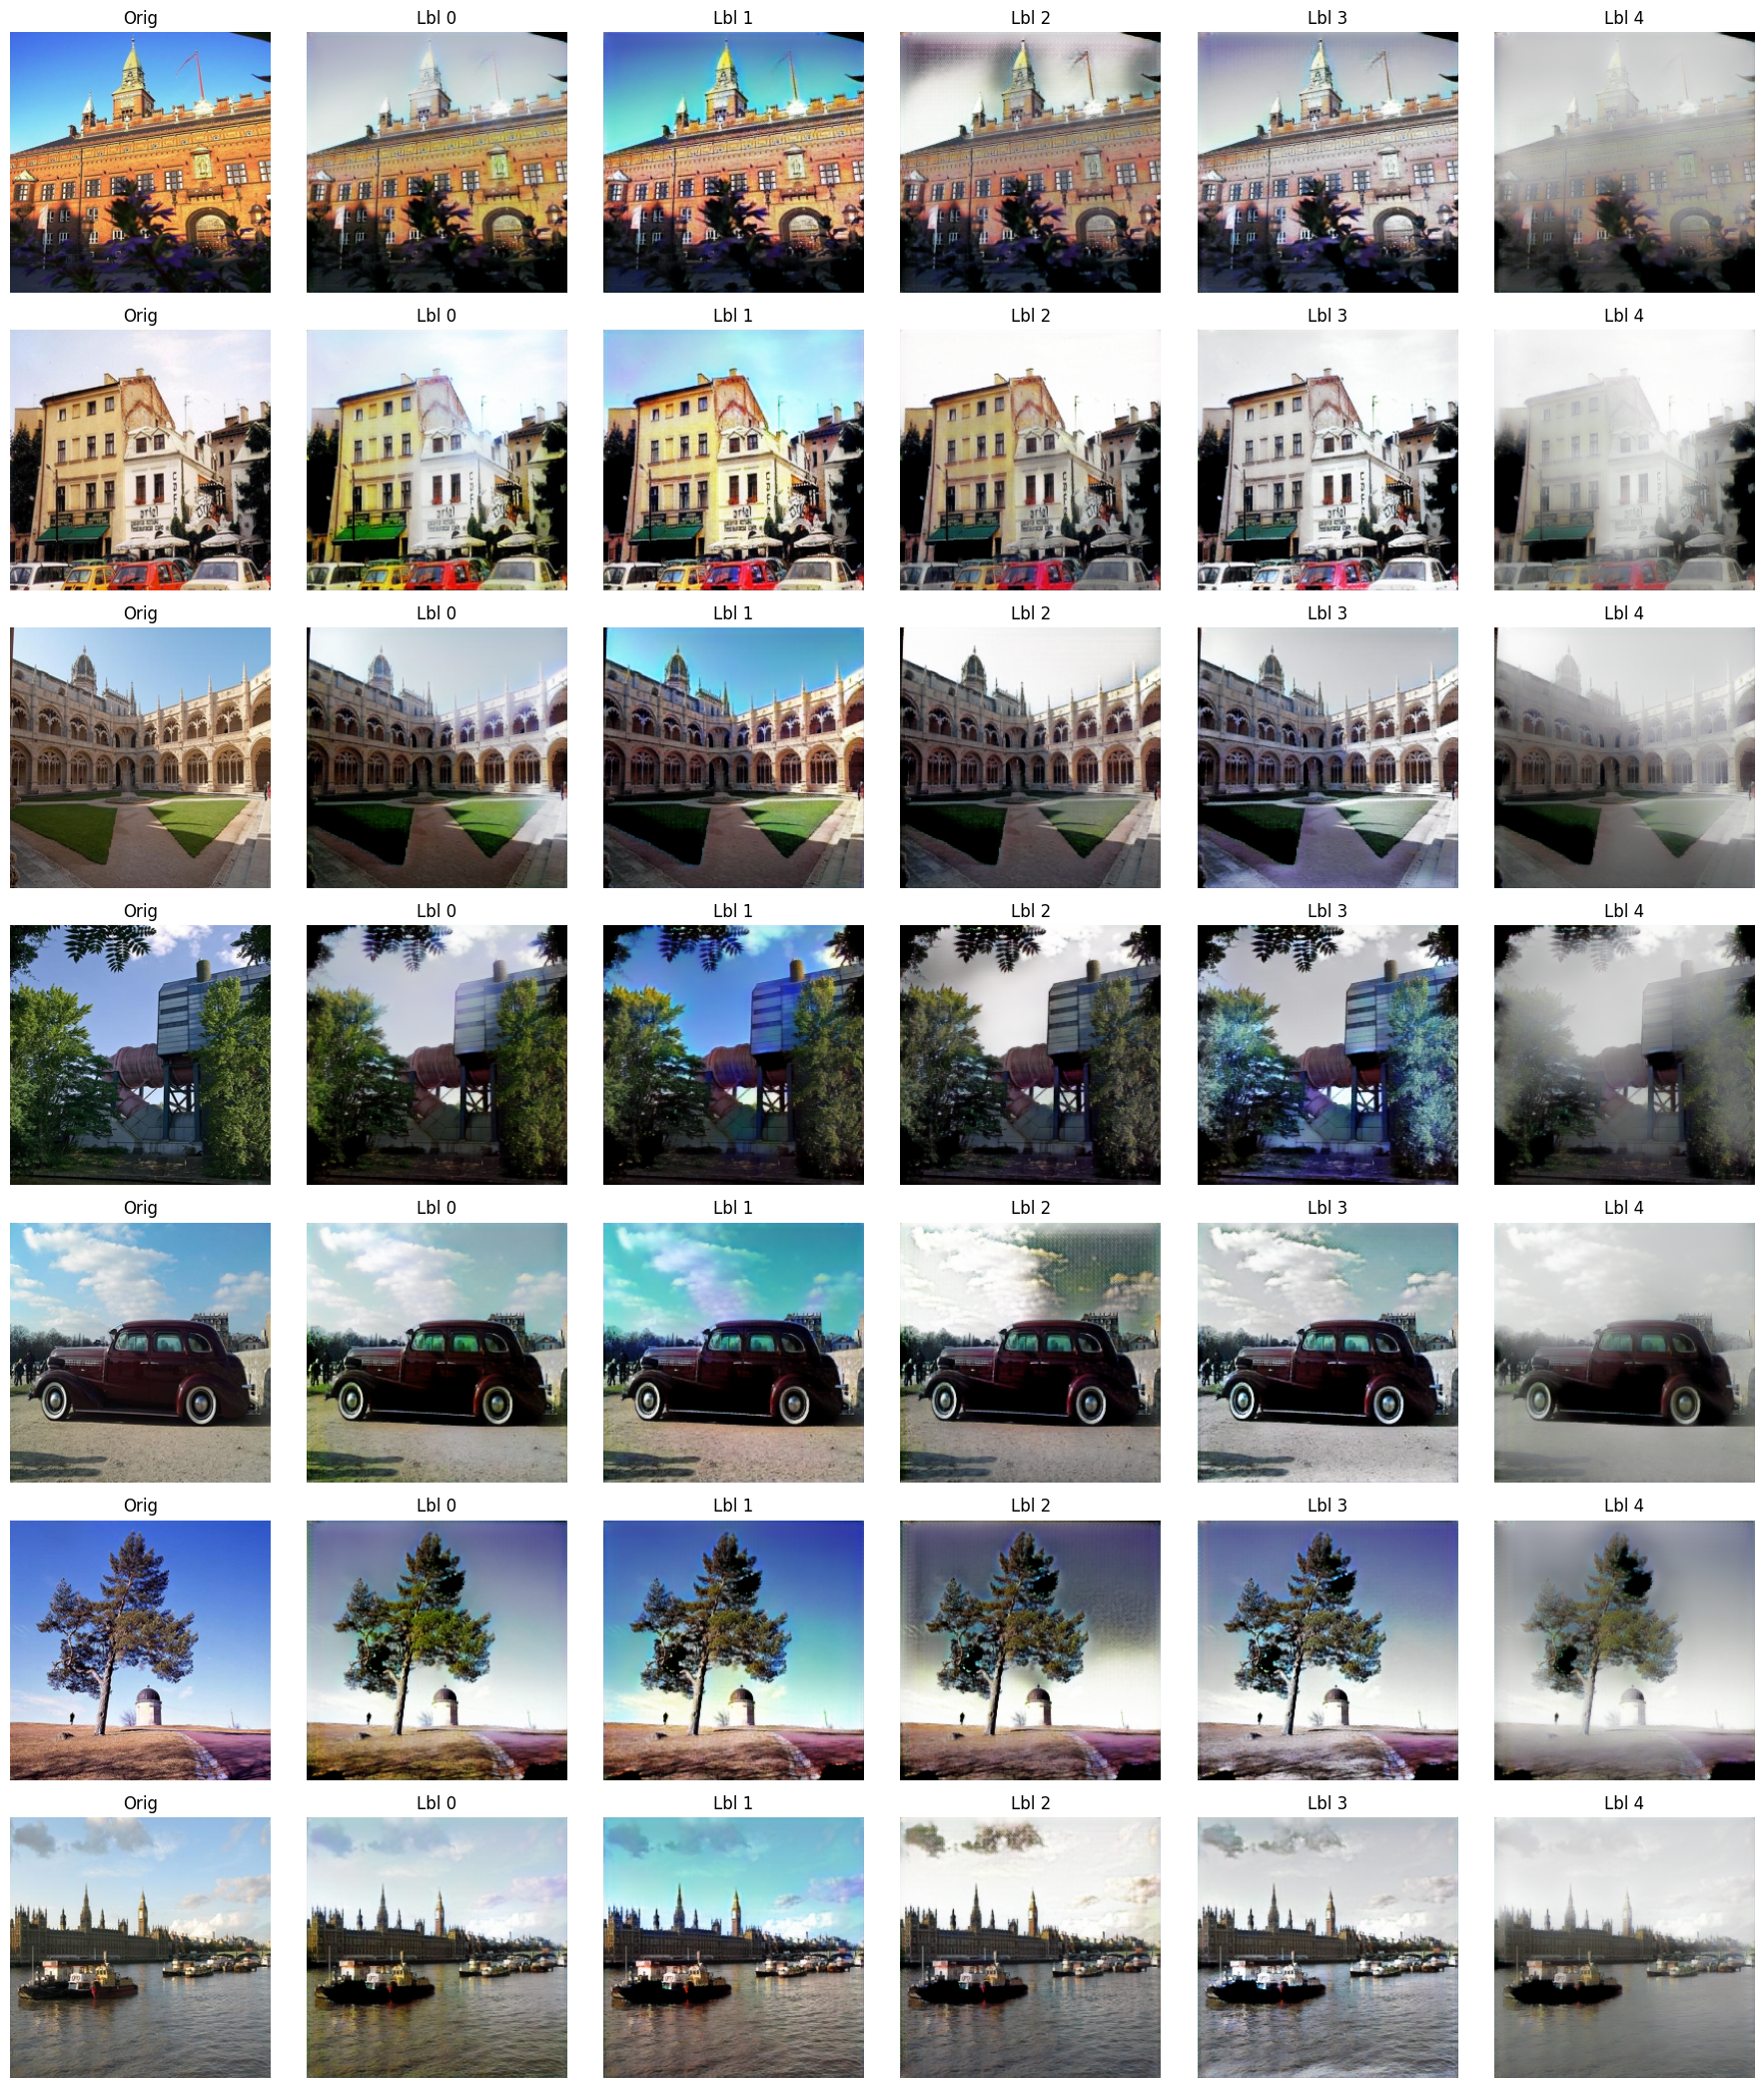

In [5]:
# Inference for 10 images from class '0' and all target labels
import torch
import os
import random
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) define transforms (must match training)
transform_in = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# 2) helper to undo Normalize
unnormalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std =[2.0,  2.0,  2.0]
)

# 3) load checkpoint & build model
ckpt = torch.load('./checkpoints/perceptual/v1/ckpt_epoch_45.pt', map_location=device)
# If model was trained with DataParallel, wrap before loading state dict

G = Generator().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    G = nn.DataParallel(G)
G.load_state_dict(ckpt['G_state'])
G.eval()

# 4) inference function
def infer(img_path, target_label):
    img = Image.open(img_path).convert('RGB')
    x = transform_in(img).unsqueeze(0).to(device)
    lbl = torch.tensor([target_label], device=device)
    # handle DataParallel vs single‐GPU
    num_classes = G.module.n_classes if hasattr(G, 'module') else G.n_classes
    lbl_onehot = F.one_hot(lbl, num_classes=num_classes).float().to(device)
    with torch.no_grad():
        fake = G(x, target_label=lbl_onehot)
    # undo normalization & clamp
    fake = unnormalize(fake.squeeze(0).cpu()).clamp(0,1)
    return img, transforms.ToPILImage()(fake)

# Inference for 10 images from class '0' and all target labels
base_path = '/kaggle/working/Weather-Detection-Using-Images/Data'
dir0 = os.path.join(base_path, '1')
# dir0 = "/kaggle/input/lhq-1024/dataset"
files0 = sorted([f for f in os.listdir(dir0) if f.lower().endswith(('.jpg', '.png'))])
files0 = random.sample(files0, min(7, len(files0)))
num_labels = G.module.n_classes if hasattr(G, 'module') else G.n_classes
fig, axes = plt.subplots(len(files0), 1 + num_labels, figsize=(3*(1+num_labels), 3*len(files0)))
for i, fname in enumerate(files0):
    path = os.path.join(dir0, fname)
    img_orig = Image.open(path).convert('RGB')
    img_resized = img_orig.resize((256,256))
    axes[i, 0].imshow(img_resized); axes[i, 0].axis('off'); axes[i, 0].set_title('Orig')
    for lb in range(num_labels):
        _, gen = infer(path, target_label=lb)
        axes[i, lb+1].imshow(gen); axes[i, lb+1].axis('off'); axes[i, lb+1].set_title(f'Lbl {lb}')
plt.tight_layout(); plt.show()

In [ ]:
!ls /kaggle/working/Weather-Detection-Using-Images/Data/2